In [1]:
import os
import logging
import sys
from dotenv import load_dotenv

load_dotenv()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
from llama_index.llms.databricks import Databricks
from langchain_huggingface import HuggingFaceEmbeddings
from llama_index.embeddings.langchain import LangchainEmbedding
from llama_index.core import Settings


Settings.llm = Databricks(
    model="databricks-meta-llama-3-1-70b-instruct",
    api_key=os.environ["DATABRICKS_TOKEN"],
    api_base="https://adb-7215147325717155.15.azuredatabricks.net/serving-endpoints",
)
Settings.embed_model = LangchainEmbedding(HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))

c:\Users\NailFerroukhi\miniconda3\envs\sid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:datasets:PyTorch version 2.4.0 available.
PyTorch version 2.4.0 available.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


c:\Users\NailFerroukhi\miniconda3\envs\sid\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from llama_index.core import SimpleDirectoryReader

docs = SimpleDirectoryReader("../../data/pdf/resume").load_data()

In [4]:
from llama_index.core.node_parser import SentenceSplitter

node_parser = SentenceSplitter(chunk_size=1024)
nodes = node_parser.get_nodes_from_documents(docs)

# by default, the node ids are set to random uuids. To ensure same id's per run, we manually set them.
for idx, node in enumerate(nodes):
    node.id_ = f"node_{idx}"

[77, 826, 377, 936, 240, 585, 949, 272, 958, 357, 923, 313, 938, 425, 889, 419, 928, 409, 896, 483, 949, 937, 237, 956, 921, 120, 788, 961, 367, 529, 878, 500, 836, 570, 510, 881, 765, 810, 196, 597, 661, 526, 372, 228, 740, 247, 518, 963, 74, 815, 917, 385, 954, 236, 687, 664, 1, 423, 916, 247, 944, 156, 905, 191, 609, 609, 843, 964, 90, 591, 897, 477, 638, 682, 675, 514, 201, 272, 495, 840, 320, 939, 251, 941, 305, 951, 233, 736, 489, 952, 244, 894, 346, 933, 326, 913, 197, 947, 310, 950, 933, 260, 911, 222, 943, 139, 930, 176, 877, 289, 937, 251, 870, 232, 891, 932, 226, 955, 940, 928, 415, 944, 254, 960, 434, 901, 313, 955, 194, 208]


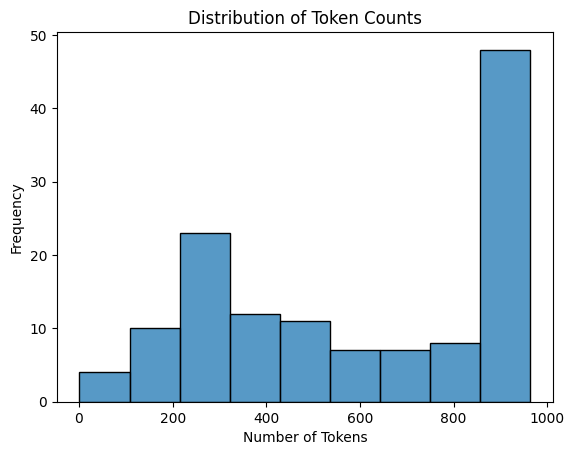

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-70B")

import seaborn as sns
import matplotlib.pyplot as plt

token_counts = []
for i in range(len(nodes)):
    tokens = tokenizer.tokenize(nodes[i].get_content())
    num_tokens = len(tokens)
    token_counts.append(num_tokens)
print(token_counts)    
sns.histplot(token_counts, kde=False)
plt.title("Distribution of Token Counts")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [6]:
len(nodes)

130

In [7]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
COHERE_API_KEY = os.environ.get('COHERE_API_KEY')
# Setup Cohere reranker
cohere_rerank = CohereRerank(api_key=COHERE_API_KEY, top_n=5)


c:\Users\NailFerroukhi\miniconda3\envs\sid\lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


In [8]:
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex(nodes)

In [9]:
retriever = index.as_retriever(similarity_top_k=10)
query_engine = index.as_query_engine(similarity_top_k=10, node_postprocessors=[cohere_rerank])

In [26]:
import pandas as pd
from datasets import Dataset

# Read test set
testset = pd.read_parquet("../../data/parquet/dataset.parquet")

questions = testset[:100]["question"].tolist()
answers = []
contexts = []

p_nodes = []
# Inference
for query in questions:
  nodes = cohere_rerank.postprocess_nodes(retriever.retrieve(query), query_str=query)
  answers.append(query_engine.query(query).response)
  for node in nodes:
    p_nodes.append(node.text)
  contexts.append(p_nodes)
  

INFO:httpx:HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://adb-7215147325717155.15.azuredatabricks.net/serving-endpoints/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://adb-7215147325717155.15.azuredatabricks.net/serving-endpoints/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://adb-7215147325717155.15.azuredatabricks.net/serving-endpoints/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
HTTP Request: POST https

In [32]:
# To dict
data = {
    "question": testset[:100]["question"].tolist(),
    "answer": answers,
    "contexts": contexts,
    "ground_truth": testset[:100]["ground_truth"].tolist()
}

print(data)
# Convert dict to dataset
# dataset = Dataset.from_dict(data)
# print(dataset)

In [28]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

df = result.to_pandas()

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 

Evaluating:   0%|          | 1/400 [00:35<3:57:49, 35.76s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
H

Evaluating:   0%|          | 2/400 [01:24<4:47:20, 43.32s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.910012 seconds
Retrying request to /chat/completions in 0.910012 seconds
Retrying request to /chat/completions in 0.910012 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INF

Evaluating:   1%|          | 3/400 [02:03<4:33:18, 41.31s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.884028 seconds
Retrying request to /chat/completions in 0.884028 seconds
Retrying request to /chat/completions in 0.884028 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.873408 seconds
Retrying request to /chat/completions in 0.873408 seconds
Retrying request to /chat/completions in 0.873408 seconds
INFO:httpx

Evaluating:   1%|          | 4/400 [03:00<5:12:53, 47.41s/it]

ERROR:ragas.executor:Exception raised in Job[390]: TimeoutError()
Exception raised in Job[390]: TimeoutError()
Exception raised in Job[390]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[398]: TimeoutError()
Exception raised in Job[398]: TimeoutError()
Exception raised in Job[398]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[394]: TimeoutError()
Exception raised in Job[394]: TimeoutError()
Exception raised in Job[394]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[245]: TimeoutError()
Exception raised in Job[245]: TimeoutError()
Exception raised in Job[245]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[392]: TimeoutError()
Exception raised in Job[392]: TimeoutError()
Exception raised in Job[392]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[396]: TimeoutError()
Exception raised in Job[396]: TimeoutError()
Exception raised in Job[396]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[393]: TimeoutError(

Evaluating:   4%|▍         | 17/400 [03:35<51:45,  8.11s/it] 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
H

Evaluating:   4%|▍         | 18/400 [04:24<1:14:20, 11.68s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.820857 seconds
Retrying request to /chat/completions in 1.820857 seconds
Retrying request to /chat/completions in 1.820857 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.

Evaluating:   5%|▍         | 19/400 [04:39<1:16:23, 12.03s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 0.988247 seconds
Retrying request to /chat/completions in 0.988247 seconds
Retrying request to /chat/completions in 0.988247 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.970520 seconds
Retrying request to /chat/completions in 1.970520 seconds
Retrying request to /chat/completions in 1.970520 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1

Evaluating:   5%|▌         | 20/400 [04:52<1:17:23, 12.22s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 1.613336 seconds
Retrying request to /chat/completions in 1.613336 seconds
Retrying request to /chat/completions in 1.613336 seconds
ERROR:ragas.executor:Exception raised in Job[254]: APIConnectionError(Connection error.)
Exception raised in Job[254]: APIConnectionError(Connection error.)
Exception raised in Job[254]: APIConnectionError(Connection error.)


Evaluating:   5%|▌         | 21/400 [04:52<1:04:36, 10.23s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.666998 seconds
Retrying request to /chat/completions in 1.666998 seconds
Retrying request to /chat/completions in 1.666998 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INF

Evaluating:   6%|▌         | 22/400 [05:03<1:04:45, 10.28s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.589962 seconds
Retrying request to /chat/completions in 1.589962 seconds
Retrying request to /chat/completions in 1.589962 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:   6%|▌         | 23/400 [05:17<1:09:33, 11.07s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.819280 seconds
Retrying request to /chat/completions in 0.819280 seconds
Retrying request to /chat/completions in 0.819280 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INF

Evaluating:   6%|▌         | 24/400 [05:26<1:07:31, 10.78s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
INFO:openai._base_client:Retrying request to /chat/completions in 1.536741 seconds
Retrying request to /chat/completions in 1.536741 seconds
Retrying request to /chat/completions in 1.536741 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.753915 seconds
Retrying request to /chat/completions in 0.753915 seconds
Retrying request to /chat/completions in 0.753915 seconds
INFO:httpx:HTTP Request: POS

Evaluating:   6%|▋         | 25/400 [05:32<58:23,  9.34s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.634239 seconds
Retrying request to /chat/completions in 1.634239 seconds
Retrying request to /chat/completions in 1.634239 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INF

Evaluating:   6%|▋         | 26/400 [05:51<1:15:31, 12.12s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.

Evaluating:   7%|▋         | 27/400 [06:00<1:08:47, 11.07s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:ragas.executor:Exception raised in Job[106]: TimeoutError()
Exception raised in Job[106]: TimeoutError()
Exception raised in Job[106]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[251]: TimeoutError()
Exception raised in Job[251]: TimeoutError()
Exception raised in Job[251]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[108]: TimeoutError()
Exception raised in Job[108]: TimeoutError()
Exception raised in Job[108]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[109]: TimeoutError()
Exception raised in Job[109]: TimeoutError()
Exception raised in Job[109]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[253]: TimeoutError()
Exception raised in Job[253]: TimeoutError()
Exception rais

Evaluating:   8%|▊         | 34/400 [06:01<18:53,  3.10s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
ERROR:ragas.executor:Exception raised in Job[258]: InternalServerError(<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>)
Exception raised in Job[258]: InternalServerError(<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>)
Exception raised in Job[258]: InternalServerError(<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>)


Evaluating:   9%|▉         | 35/400 [06:01<16:36,  2.73s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/c

Evaluating:   9%|▉         | 36/400 [06:35<46:19,  7.64s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.786552 seconds
Retrying request to /chat/completions in 0.786552 seconds
Retrying request to /chat/completions in 0.786552 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INF

Evaluating:   9%|▉         | 37/400 [07:24<1:31:21, 15.10s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.941325 seconds
Retrying request to /chat/completions in 0.941325 seconds
Retrying request to /chat/completions in 0.941325 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.

Evaluating:  10%|▉         | 38/400 [07:39<1:30:42, 15.03s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST ht

Evaluating:  10%|▉         | 39/400 [08:17<2:02:13, 20.31s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.984789 seconds
Retrying request to /chat/completions in 0.984789 seconds
Retrying request to /chat/completions in 0.984789 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.837740 seconds
Retrying request to /chat/completions in 0.837740 seconds
Retrying request to /chat/completions in 0.837740 seconds
INFO:httpx

Evaluating:  10%|█         | 40/400 [08:27<1:46:22, 17.73s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.778778 seconds
Retrying request to /chat/completions in 0.778778 seconds
Retrying request to /chat/completions in 0.778778 seconds
INF

Evaluating:  10%|█         | 41/400 [08:32<1:26:22, 14.44s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.885836 seconds
Retrying request to /chat/completions in 1.885836 seconds
Retrying request to /chat/completions in 1.885836 seconds
INF

Evaluating:  10%|█         | 42/400 [08:37<1:11:50, 12.04s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
H

Evaluating:  11%|█         | 43/400 [08:51<1:15:17, 12.65s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.827254 seconds
Retrying request to /chat/completions in 0.827254 seconds
Retrying request

Evaluating:  11%|█         | 44/400 [09:00<1:07:28, 11.37s/it]

ERROR:ragas.executor:Exception raised in Job[262]: TimeoutError()
Exception raised in Job[262]: TimeoutError()
Exception raised in Job[262]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[117]: TimeoutError()
Exception raised in Job[117]: TimeoutError()
Exception raised in Job[117]: TimeoutError()


Evaluating:  11%|█▏        | 45/400 [09:00<48:14,  8.15s/it]  

ERROR:ragas.executor:Exception raised in Job[118]: TimeoutError()
Exception raised in Job[118]: TimeoutError()
Exception raised in Job[118]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[261]: TimeoutError()
Exception raised in Job[261]: TimeoutError()
Exception raised in Job[261]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[119]: TimeoutError()
Exception raised in Job[119]: TimeoutError()
Exception raised in Job[119]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[263]: TimeoutError()
Exception raised in Job[263]: TimeoutError()
Exception raised in Job[263]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[264]: TimeoutError()
Exception raised in Job[264]: TimeoutError()
Exception raised in Job[264]: TimeoutError()


Evaluating:  13%|█▎        | 51/400 [09:01<14:28,  2.49s/it]

ERROR:ragas.executor:Exception raised in Job[120]: TimeoutError()
Exception raised in Job[120]: TimeoutError()
Exception raised in Job[120]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.open

Evaluating:  13%|█▎        | 53/400 [09:35<35:52,  6.20s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 

Evaluating:  14%|█▎        | 54/400 [10:24<1:13:05, 12.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.655863 seconds
Retrying request to /chat/completions in 1.655863 seconds
Retrying request to /chat/completions in 1.655863 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.781080 seconds
Retrying request to /chat/completions in 0.781080 seconds
Retrying request to /chat/completions in 0.781080 seconds
INFO:httpx

Evaluating:  14%|█▍        | 55/400 [10:51<1:27:56, 15.29s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.912120 seconds
Retrying request to /chat/completions in 0.912120 seconds
Retrying request to /chat/completions in 0.912120 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INF

Evaluating:  14%|█▍        | 56/400 [11:12<1:33:54, 16.38s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.915690 seconds
Retrying request to /chat/completions in 0.915690 seconds
Retrying request to /chat/completions in 0.915690 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  14%|█▍        | 58/400 [11:17<1:04:27, 11.31s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.786040 seconds
Retrying request to /chat/completions in 1.786040 seconds
Retrying request to /chat/completions in 1.786040 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.846259 seconds
Retrying request to /chat/completions in 0.846259 seconds
Retrying request to /chat/completions in 0.846259 seconds
INFO:httpx

Evaluating:  15%|█▍        | 59/400 [11:27<1:02:25, 10.99s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.950214 seconds
Retrying request to /chat/completions in 1.950214 seconds
Retrying request to /chat/completions in 1.950214 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.796783 seconds
Retrying request to /chat/completions in 0.796783 seconds
Retrying request to /chat/completions in 0.796783 seconds
INFO:httpx

Evaluating:  15%|█▌        | 60/400 [11:32<54:25,  9.60s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.997443 seconds
Retrying request to /chat/completions in 0.997443 seconds
Retrying request to /chat/completions in 0.997443 seconds
INFO:httpx

Evaluating:  15%|█▌        | 61/400 [11:37<48:28,  8.58s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.950899 seconds
Retrying request to /chat/completions in 0.950899 seconds
Retrying request to /chat/completions in 0.950899 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.751287 seconds
Retrying request to /chat/completions in 0.751287 seconds
Retrying request to /chat/completions in 0.751287 seconds
INFO:httpx

Evaluating:  16%|█▌        | 62/400 [11:51<56:39, 10.06s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.919722 seconds
Retrying request to /chat/completions in 0.919722 seconds
Retrying request to /chat/completions in 0.919722 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.963108 seconds
Retrying request to /chat/completions in 0.963108 seconds
Retrying request to /chat/completions in 0.963108 seconds
INFO:httpx

Evaluating:  16%|█▌        | 63/400 [12:00<54:09,  9.64s/it]

ERROR:ragas.executor:Exception raised in Job[127]: TimeoutError()
Exception raised in Job[127]: TimeoutError()
Exception raised in Job[127]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[272]: TimeoutError()
Exception raised in Job[272]: TimeoutError()
Exception raised in Job[272]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.780106 seconds
Retrying request to /chat/completions in 0.780106 seconds
Retrying request to /chat/completions in 0.780106 seconds
ERROR:ragas.executor:Exception raised in Job[132]: APIConnectionError(Connection error.)
Exception raised in Job[132]: APIConnectionError(Connection error.)
Exception raised in Job[132]: APICon

Evaluating:  17%|█▋        | 67/400 [12:01<21:54,  3.95s/it]

ERROR:ragas.executor:Exception raised in Job[128]: TimeoutError()
Exception raised in Job[128]: TimeoutError()
Exception raised in Job[128]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[273]: TimeoutError()
Exception raised in Job[273]: TimeoutError()
Exception raised in Job[273]: TimeoutError()


Evaluating:  17%|█▋        | 69/400 [12:01<15:19,  2.78s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.776821 seconds
Retrying request to /chat/completions in 0.776821 seconds
Retrying request to /chat/completions in 0.776821 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  18%|█▊        | 70/400 [12:35<46:02,  8.37s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.922396 seconds
Retrying request to /chat/completions in 0.922396 seconds
Retrying request to /chat/completions in 0.922396 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.787208 seconds
Retrying request to /chat/completions in 0.787208 seconds
Retrying request to /chat/completions in 0.787208 seconds
INFO:httpx

Evaluating:  18%|█▊        | 71/400 [13:24<1:30:25, 16.49s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.762257 seconds
Retrying request to /chat/com

Evaluating:  18%|█▊        | 72/400 [13:36<1:24:41, 15.49s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 1.686695 seconds
Retrying request to /chat/completions in 1.686695 seconds
Retrying request to /chat/completions in 1.686695 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.962254 seconds
Retrying request to /chat/completions in 0.962254 seconds
Retrying request to /chat/completions in 0.962254 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:opena

Evaluating:  18%|█▊        | 73/400 [13:51<1:24:05, 15.43s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.778900 seconds
Retrying request to /chat/completions in 0.778900 seconds
Retrying request to /chat/completions in 0.778900 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  18%|█▊        | 74/400 [14:12<1:31:11, 16.79s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.518896 seconds
Retrying request to /chat/completions in 1.518896 seconds
Retrying request to /chat/completions in 1.518896 seconds
INFO:httpx

Evaluating:  19%|█▉        | 76/400 [14:17<57:56, 10.73s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.789685 seconds
Retrying request to /chat/completions in 0.789685 seconds
Retrying request to /chat/completions in 0.789685 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  19%|█▉        | 77/400 [14:32<1:02:54, 11.68s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  20%|█▉        | 78/400 [14:37<54:22, 10.13s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  20%|█▉        | 79/400 [14:51<1:00:00, 11.22s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.553653 seconds
Retrying request to /chat/completions in 1.553653 seconds
Retrying request to /chat/completions in 1.553653 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  20%|██        | 80/400 [15:00<55:52, 10.48s/it]  

ERROR:ragas.executor:Exception raised in Job[279]: TimeoutError()
Exception raised in Job[279]: TimeoutError()
Exception raised in Job[279]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[280]: TimeoutError()
Exception raised in Job[280]: TimeoutError()
Exception raised in Job[280]: TimeoutError()


Evaluating:  20%|██        | 82/400 [15:00<31:30,  5.94s/it]

ERROR:ragas.executor:Exception raised in Job[136]: TimeoutError()
Exception raised in Job[136]: TimeoutError()
Exception raised in Job[136]: TimeoutError()


Evaluating:  21%|██        | 83/400 [15:01<25:05,  4.75s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[281]: TimeoutError()
Exception raised in Job[281]: TimeoutError()
Exception raised in Job[281]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[137]: TimeoutError()
Exception raised in Job[137]: TimeoutError()
Exception raised in Job[137]: TimeoutError()


Evaluating:  21%|██▏       | 85/400 [15:01<15:11,  2.89s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.837992 seconds
Retrying request to /chat/completions in 0.837992 seconds
Retrying request to /chat/completions in 0.837992 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  22%|██▏       | 86/400 [15:35<51:41,  9.88s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  22%|██▏       | 87/400 [16:24<1:40:21, 19.24s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  22%|██▏       | 88/400 [16:36<1:30:24, 17.39s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.765807 seconds
Retrying request to /chat/completions in 1.765807 seconds
Retrying request to /chat/completions in 1.765807 seconds
INFO:httpx

Evaluating:  22%|██▏       | 89/400 [16:51<1:27:08, 16.81s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.914516 seconds
Retrying request to /chat/completions in 0.914516 seconds
Retrying request to /chat/completions in 0.914516 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  22%|██▎       | 90/400 [17:12<1:32:17, 17.86s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.782599 seconds
Retrying request to /chat/completions in 1.782599 seconds
Retrying request to /chat/completions in 1.782599 seconds
INFO:httpx

Evaluating:  23%|██▎       | 92/400 [17:17<56:53, 11.08s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.972834 seconds
Retrying request to /chat/completions in 0.972834 seconds
Retrying request to /chat/completions in 0.972834 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.511842 seconds
Retrying request to /chat/completions in 1.511842 seconds
Retrying request to /chat/completions in 1.511842 seconds
INFO:httpx

Evaluating:  23%|██▎       | 93/400 [17:32<1:01:27, 12.01s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  24%|██▎       | 94/400 [17:37<52:36, 10.31s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  24%|██▍       | 95/400 [17:51<57:57, 11.40s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.776444 seconds
Retrying request to /chat/completions in 0.776444 seconds
Retrying request to /chat/completions in 0.776444 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  24%|██▍       | 96/400 [18:00<53:31, 10.57s/it]

ERROR:ragas.executor:Exception raised in Job[143]: TimeoutError()
Exception raised in Job[143]: TimeoutError()
Exception raised in Job[143]: TimeoutError()


Evaluating:  24%|██▍       | 97/400 [18:00<38:34,  7.64s/it]

ERROR:ragas.executor:Exception raised in Job[288]: TimeoutError()
Exception raised in Job[288]: TimeoutError()
Exception raised in Job[288]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.950646 seconds
Retrying request to /chat/completions in 0.950646 seconds
Retrying request to /chat/completions in 0.950646 seconds
ERROR:ragas.executor:Exception raised in Job[144]: TimeoutError()
Exception raised in Job[144]: TimeoutError()
Exception raised in Job[144]: TimeoutError()


Evaluating:  25%|██▍       | 99/400 [18:01<22:01,  4.39s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:ragas.executor:Exception raised in Job[289]: TimeoutError()
Exception raised in Job[289]: TimeoutError()
Exception raised in Job[289]: TimeoutError()


Evaluating:  25%|██▌       | 100/400 [18:01<16:57,  3.39s/it]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/cha

Evaluating:  26%|██▌       | 102/400 [18:35<44:47,  9.02s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.679899 seconds
Retrying request to /chat/completions in 1.679899 seconds
Retrying request to /chat/completions in 1.679899 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.752769 seconds
Retrying request to /chat/completions in 0.752769 seconds
Retrying request to /chat/completions in 0.752769 seconds
INFO:httpx

Evaluating:  26%|██▌       | 103/400 [19:24<1:28:43, 17.93s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  26%|██▌       | 104/400 [19:36<1:21:20, 16.49s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.793322 seconds
Retrying request to /chat/completions in 0.793322 seconds
Retrying request to /chat/completions in 0.793322 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.857434 seconds
Retrying request to /chat/completions in 0.857434 seconds
Retrying request to /chat/completions in 0.857434 seconds
INFO:httpx

Evaluating:  26%|██▋       | 105/400 [19:51<1:19:47, 16.23s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/c

Evaluating:  26%|██▋       | 106/400 [20:12<1:24:59, 17.35s/it]

ERROR:ragas.executor:Exception raised in Job[2]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[2]: TimeoutError()


Evaluating:  27%|██▋       | 107/400 [20:12<1:01:40, 12.63s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 1.659926 seconds
Retrying request to /chat/completions in 1.659926 seconds
Retrying request to /chat/completions in 1.659926 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[147]: InternalServerError(<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>)
Excepti

Evaluating:  27%|██▋       | 109/400 [20:31<53:58, 11.13s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.582467 seconds
Retrying request to /chat/completions in 1.582467 seconds
Retrying request to /chat/completions in 1.582467 seconds
ERROR:ragas.executor:Exception raised in Job[292]: TimeoutError()
Exception raised in Job[292]: TimeoutError()
Exception raised in Job[292]: TimeoutError()


Evaluating:  28%|██▊       | 110/400 [20:32<42:04,  8.70s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.680905 seconds
Retrying request to /chat/completions in 1.680905 seconds
Retrying request to /chat/completions in 1.680905 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  28%|██▊       | 111/400 [20:37<37:56,  7.88s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.801717 seconds
Retrying request to /chat/completions in 0.801717 seconds
Retrying request to /chat/completions in 0.801717 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  28%|██▊       | 112/400 [20:40<31:04,  6.47s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  28%|██▊       | 114/400 [20:51<29:31,  6.19s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.918454 seconds
Retrying request to /chat/completions in 0.918454 seconds
Retrying request to /chat/completions in 0.918454 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  29%|██▉       | 115/400 [21:00<32:00,  6.74s/it]

ERROR:ragas.executor:Exception raised in Job[4]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[149]: TimeoutError()
Exception raised in Job[149]: TimeoutError()
Exception raised in Job[149]: TimeoutError()


Evaluating:  29%|██▉       | 117/400 [21:00<19:22,  4.11s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:ragas.executor:Exception raised in Job[294]: TimeoutError()
Exception raised in Job[294]: TimeoutError()
Exception raised in Job[294]: TimeoutError()


Evaluating:  30%|██▉       | 118/400 [21:01<15:32,  3.31s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.969229 seconds
Retrying request to /chat/completions in 1.969229 seconds
Retrying request to /chat/completions in 1.969229 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.996502 seconds
Retrying request to /chat/completions in 0.996502 seconds
Retrying request to /chat/completions in 0.996502 seconds
INFO:httpx

Evaluating:  30%|██▉       | 119/400 [21:07<19:17,  4.12s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.981982 seconds
Retrying request to /chat/completions in 0.981982 seconds
Retrying request to /chat/completions in 0.981982 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  30%|███       | 120/400 [21:35<47:45, 10.23s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.657092 seconds
Retrying request to /chat/completions in 1.657092 seconds
Retrying request to /chat/completions in 1.657092 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  30%|███       | 121/400 [22:00<1:05:05, 14.00s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/c

Evaluating:  30%|███       | 122/400 [22:08<57:13, 12.35s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 1.964229 seconds
Retrying request to /chat/completions in 1.964229 seconds
Retrying request to /chat/completions in 1.964229 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:opena

Evaluating:  31%|███       | 123/400 [22:24<1:01:57, 13.42s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  31%|███       | 124/400 [22:35<58:26, 12.70s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  32%|███▏      | 126/400 [22:36<32:57,  7.22s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.805261 seconds
Retrying request to /chat/com

Evaluating:  32%|███▏      | 127/400 [22:58<49:57, 10.98s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.841843 seconds
Retrying request to /chat/completions in 1.841843 seconds
Retrying request to /chat/completions in 1.841843 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
HTTP Request: POST h

Evaluating:  32%|███▏      | 128/400 [23:12<52:55, 11.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.727846 seconds
Retrying request to /chat/completions in 1.727846 seconds
Retrying request to /chat/completions in 1.727846 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  32%|███▏      | 129/400 [23:30<1:00:51, 13.47s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.976912 seconds
Retrying request to /chat/completions in 0.976912 seconds
Retrying request to /chat/completions in 0.976912 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.933214 seconds
Retrying request to /chat/completions in 0.933214 seconds
Retrying request to /chat/completions in 0.933214 seconds
INFO:httpx

Evaluating:  32%|███▎      | 130/400 [23:37<51:59, 11.55s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.658873 seconds
Retrying request to /chat/completions in 1.658873 seconds
Retrying request to /chat/completions in 1.658873 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
ERROR:raga

Evaluating:  33%|███▎      | 131/400 [23:40<40:34,  9.05s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.936159 seconds
Retrying request to /chat/completions in 0.936159 seconds
Retrying request to /chat/completions in 0.936159 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.927079 seconds
Retrying request to /chat/completions in 0.927079 seconds
Retrying request to /chat/completions in 0.927079 seconds
INFO:httpx

Evaluating:  33%|███▎      | 132/400 [23:51<43:37,  9.77s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  33%|███▎      | 133/400 [24:00<42:04,  9.45s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.675970 seconds
Retrying request to /chat/completions in 1.675970 seconds
Retrying request to /chat/completions in 1.675970 seconds
ERROR:ragas.executor:Exception raised in Job[300]: TimeoutError()
Exception raised in Job[300]: TimeoutError()
Exception raised in Job[300]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[11]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[11]: TimeoutError()


Evaluating:  34%|███▍      | 135/400 [24:01<23:31,  5.33s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.840722 seconds
Retrying request to /chat/completions in 0.840722 seconds
Retrying request to /chat/completions in 0.840722 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  34%|███▍      | 136/400 [24:18<36:03,  8.20s/it]

ERROR:ragas.executor:Exception raised in Job[157]: APIConnectionError(Connection error.)
Exception raised in Job[157]: APIConnectionError(Connection error.)
Exception raised in Job[157]: APIConnectionError(Connection error.)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.859353 seconds
Retrying request to /chat/completions in 1.859353 seconds
Retrying request to /chat/completions in 1.859353 seconds


Evaluating:  35%|███▌      | 140/400 [24:18<14:56,  3.45s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP R

Evaluating:  35%|███▌      | 141/400 [24:32<22:45,  5.27s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.959247 seconds
Retrying request to /chat/completions in 0.959247 seconds
Retrying request to /chat/completions in 0.959247 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.586385 seconds
Retrying request to /chat/completions in 1.586385 seconds
Retrying request to /chat/completions in 1.586385 seconds
INFO:httpx

Evaluating:  36%|███▌      | 142/400 [24:35<20:59,  4.88s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.972214 seconds
Retrying request to /chat/completions in 0.972214 seconds
Retrying request to /chat/completions in 0.972214 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  36%|███▌      | 143/400 [24:58<37:33,  8.77s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  36%|███▌      | 144/400 [24:59<30:01,  7.04s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[302]: APIConnectionError(Connection error.)
Exception raised in Job[302]: APIConnectionError(Connection error.)
Exception raised in Job[302]: APIConnectionError(Connection error.)


Evaluating:  36%|███▋      | 145/400 [25:02<24:31,  5.77s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.872371 seconds
Retrying request to /chat/com

Evaluating:  36%|███▋      | 146/400 [25:18<36:42,  8.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.908252 seconds
Retrying request to /chat/completions in 0.908252 seconds
Retrying request to /chat/completions in 0.908252 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  37%|███▋      | 147/400 [25:36<47:02, 11.15s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.886117 seconds
Retrying request to /chat/completions in 0.886117 seconds
Retrying request to /chat/completions in 0.886117 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  37%|███▋      | 148/400 [26:02<1:04:53, 15.45s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.798416 seconds
Retrying request to /chat/completions in 0.798416 seconds
Retrying request to /chat/completions in 0.798416 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.988912 seconds
Retrying request to /chat/completions in 1.988912 seconds
Retrying request to /chat/completions in 1.988912 seconds
INFO:httpx

Evaluating:  38%|███▊      | 150/400 [26:16<48:00, 11.52s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.891017 seconds
Retrying request to /chat/completions in 0.891017 seconds
Retrying request to /chat/completions in 0.891017 seconds
INFO:httpx

Evaluating:  38%|███▊      | 151/400 [26:26<46:24, 11.18s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.731461 seconds
Retrying request to /chat/completions in 1.731461 seconds
Retrying request to /chat/completions in 1.731461 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  38%|███▊      | 152/400 [26:37<46:30, 11.25s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.649034 seconds
Retrying request to /chat/completions in 1.649034 seconds
Retrying request to /chat/completions in 1.649034 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  38%|███▊      | 153/400 [26:51<49:45, 12.09s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.964548 seconds
Retrying request to /chat/completions in 0.964548 seconds
Retrying request to /chat/completions in 0.964548 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.846739 seconds
Retrying request to /chat/completions in 0.846739 seconds
Retrying request to /chat/completions in 0.846739 seconds
INFO:httpx

Evaluating:  38%|███▊      | 154/400 [27:00<45:39, 11.14s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.504402 seconds
Retrying request to /chat/completions in 1.504402 seconds
Retrying request to /chat/completions in 1.504402 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.511088 seconds
Retrying request to /chat/completions in 1.511088 seconds
Retrying request to /chat/completions in 1.511088 seconds
INFO:httpx

Evaluating:  39%|███▉      | 155/400 [27:17<51:51, 12.70s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.963431 seconds
Retrying request to /chat/completions in 0.963431 seconds
Retrying request to /chat/completions in 0.963431 seconds
ERROR:ragas.executor:Exception raised in Job[307]: TimeoutError()
Exception raised in Job[307]: TimeoutError()
Exception raised in Job[307]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[17]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[18]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[18]: TimeoutError()


Evaluating:  39%|███▉      | 156/400 [27:18<38:02,  9.35s/it]

ERROR:ragas.executor:Exception raised in Job[162]: TimeoutError()
Exception raised in Job[162]: TimeoutError()
Exception raised in Job[162]: TimeoutError()


Evaluating:  39%|███▉      | 157/400 [27:18<27:00,  6.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/c

Evaluating:  40%|████      | 160/400 [27:32<22:12,  5.55s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  40%|████      | 161/400 [27:35<20:21,  5.11s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.875310 seconds
Retrying request to /chat/completions in 0.875310 seconds
Retrying request to /chat/completions in 0.875310 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  40%|████      | 162/400 [27:39<18:55,  4.77s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  41%|████      | 164/400 [28:36<55:38, 14.15s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.764707 seconds
Retrying request to /chat/completions in 0.764707 seconds
Retrying request to /chat/completions in 0.764707 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.869353 seconds
Retrying request to /chat/completions in 0.869353 seconds
Retrying request to /chat/completions in 0.869353 seconds
INFO:httpx

Evaluating:  41%|████▏     | 165/400 [29:02<1:06:00, 16.86s/it]

ERROR:ragas.executor:Exception raised in Job[166]: TimeoutError()
Exception raised in Job[166]: TimeoutError()
Exception raised in Job[166]: TimeoutError()


Evaluating:  42%|████▏     | 166/400 [29:02<50:06, 12.85s/it]  

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.835604 seconds
Retrying request to /chat/completions in 0.835604 seconds
Retrying request to /chat/completions in 0.835604 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  42%|████▏     | 167/400 [29:16<50:09, 12.92s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  42%|████▏     | 168/400 [29:26<47:03, 12.17s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 1.591703 seconds
Retrying request to /chat/completions in 1.591703 seconds
Retrying request to /chat/completions in 1.591703 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 1.824183 seconds
Retrying request to /chat/completions in 1.824183 seconds
Retrying request to /chat/completions in 1.824183 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 1.830166 seconds
Retrying request to /chat/completions in 1.830166 seconds
Retrying request to /chat/completions in 1.830166 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.912808 seconds
Retrying request to /chat/completions in 0.912808 seconds
Retrying request to /chat/completions in 0.912808 seconds
ERROR:ragas.executor:Exception raised in Job[24]: APIConnectionError(Connection error.)
Exception raised in Job[24]: APIConnectionError(Connection error.)
Exception raised in Job[24]: APIConnectionError(C

Evaluating:  42%|████▏     | 169/400 [29:26<34:17,  8.91s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.545909 seconds
Retrying request to /chat/completions in 1.545909 seconds
Retrying request to /chat/completions in 1.545909 seconds
INFO:httpx

Evaluating:  42%|████▎     | 170/400 [29:35<33:51,  8.83s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  43%|████▎     | 171/400 [29:40<29:58,  7.85s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.585972 seconds
Retrying request to /chat/completions in 1.585972 seconds
Retrying request to /chat/completions in 1.585972 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  43%|████▎     | 173/400 [30:12<43:35, 11.52s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 1.740803 seconds
Retrying request to /chat/completions in 1.740803 seconds
Retrying request to /chat/completions in 1.740803 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.864684 seconds
Retrying request to /chat/completions in 0.864684 seconds
Retrying request to /chat/completions in 0.864684 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1

Evaluating:  44%|████▎     | 174/400 [30:17<37:01,  9.83s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  44%|████▍     | 175/400 [30:18<28:29,  7.60s/it]

ERROR:ragas.executor:Exception raised in Job[169]: TimeoutError()
Exception raised in Job[169]: TimeoutError()
Exception raised in Job[169]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[314]: TimeoutError()
Exception raised in Job[314]: TimeoutError()
Exception raised in Job[314]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.861911 seconds
Retrying request to /chat/completions in 0.861911 seconds
Retrying request to /chat/completions in 0.861911 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Re

Evaluating:  44%|████▍     | 178/400 [30:32<22:31,  6.09s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.686079 seconds
Retrying request to /chat/completions in 1.686079 seconds
Retrying request to /chat/completions in 1.686079 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.929047 seconds
Retrying request to /chat/completions in 0.929047 seconds
Retrying request to /chat/completions in 0.929047 seconds
INFO:httpx

Evaluating:  45%|████▍     | 179/400 [30:36<20:32,  5.58s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.861719 seconds
Retrying request to /chat/completions in 0.861719 seconds
Retrying request to /chat/completions in 0.861719 seconds
INFO:httpx

Evaluating:  45%|████▌     | 180/400 [30:39<18:46,  5.12s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  45%|████▌     | 181/400 [30:44<18:21,  5.03s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.974358 seconds
Retrying request to /chat/completions in 0.974358 seconds
Retrying request to /chat/completions in 0.974358 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.830036 seconds
Retrying request to /chat/completions in 0.830036 seconds
Retrying request to /chat/completions in 0.830036 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:opena

Evaluating:  46%|████▌     | 182/400 [31:19<46:26, 12.78s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.852257 seconds
Retrying request to /chat/completions in 0.852257 seconds
Retrying request to /chat/completions in 0.852257 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  46%|████▌     | 184/400 [31:36<39:18, 10.92s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  46%|████▋     | 185/400 [31:45<37:22, 10.43s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.861690 seconds
Retrying request to /chat/com

Evaluating:  46%|████▋     | 186/400 [32:14<53:44, 15.07s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[27]: TimeoutError()
Exception raised in Job[27]: TimeoutError()
Exception raised in Job[27]: TimeoutError()


Evaluating:  47%|████▋     | 187/400 [32:16<41:09, 11.59s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  47%|████▋     | 188/400 [32:26<39:45, 11.25s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.911557 seconds
Retrying request to /chat/completions in 0.911557 seconds
Retrying request to /chat/completions in 0.911557 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.907848 seconds
Retrying request to /chat/completions in 1.907848 seconds
Retrying request to /chat/completions in 1.907848 seconds
INFO:httpx

Evaluating:  47%|████▋     | 189/400 [32:32<34:13,  9.73s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.757363 seconds
Retrying request to /chat/completions in 0.757363 seconds
Retrying request to /chat/completions in 0.757363 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.955825 seconds
Retrying request to /chat/completions in 1.955825 seconds
Retrying request to /chat/completions in 1.955825 seconds
INFO:httpx

Evaluating:  48%|████▊     | 190/400 [32:35<27:17,  7.80s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[29]: TimeoutError()


Evaluating:  48%|████▊     | 191/400 [32:40<24:52,  7.14s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.978830 seconds
Retrying request to /chat/com

Evaluating:  48%|████▊     | 193/400 [32:47<17:28,  5.06s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.847534 seconds
Retrying request to /chat/com

Evaluating:  48%|████▊     | 194/400 [32:47<12:25,  3.62s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.953999 seconds
Retrying request to /chat/completions in 0.953999 seconds
Retrying request to /chat/completions in 0.953999 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.813542 seconds
Retrying request to /chat/completions in 0.813542 seconds
Retrying request to /chat/completions in 0.813542 seconds
INFO:httpx

Evaluating:  49%|████▉     | 195/400 [33:12<33:54,  9.93s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.974516 seconds
Retrying request to /chat/com

Evaluating:  49%|████▉     | 196/400 [33:17<28:20,  8.34s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[175]: TimeoutError()
Exception raised in Job[175]: TimeoutError()
Exception raised in Job[175]: TimeoutError()


Evaluating:  49%|████▉     | 197/400 [33:18<21:03,  6.22s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.984297 seconds
Retrying request to /chat/completions in 0.984297 seconds
Retrying request to /chat/completions in 0.984297 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  50%|████▉     | 198/400 [33:34<30:39,  9.10s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  50%|████▉     | 199/400 [33:35<23:01,  6.87s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.812561 seconds
Retrying request to /chat/completions in 0.812561 seconds
Retrying request to /chat/completions in 0.812561 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  50%|█████     | 200/400 [33:39<19:41,  5.91s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.991103 seconds
Retrying request to /chat/completions in 0.991103 seconds
Retrying request to /chat/completions in 0.991103 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  50%|█████     | 201/400 [34:05<39:25, 11.89s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.580222 seconds
Retrying request to /chat/completions in 1.580222 seconds
Retrying request to /chat/completions in 1.580222 seconds
INFO:httpx

Evaluating:  50%|█████     | 202/400 [34:29<50:53, 15.42s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.844404 seconds
Retrying request to /chat/completions in 0.844404 seconds
Retrying request to /chat/completions in 0.844404 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.753015 seconds
Retrying request to /chat/completions in 0.753015 seconds
Retrying request to /chat/completions in 0.753015 seconds
INFO:httpx

Evaluating:  51%|█████     | 203/400 [34:36<42:40, 13.00s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.636380 seconds
Retrying request to /chat/completions in 1.636380 seconds
Retrying request to /chat/completions in 1.636380 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  51%|█████     | 204/400 [34:45<38:16, 11.72s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.990315 seconds
Retrying request to /chat/completions in 1.990315 seconds
Retrying request to /chat/completions in 1.990315 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  51%|█████▏    | 205/400 [34:54<36:12, 11.14s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.996824 seconds
Retrying request to /chat/completions in 0.996824 seconds
Retrying request to /chat/completions in 0.996824 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  52%|█████▏    | 206/400 [35:14<43:53, 13.57s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.545286 seconds
Retrying request to /chat/com

Evaluating:  52%|█████▏    | 207/400 [35:16<32:18, 10.05s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.911355 seconds
Retrying request to /chat/completions in 1.911355 seconds
Retrying request to /chat/completions in 1.911355 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.580108 seconds
Retrying request to /chat/completions in 1.580108 seconds
Retrying request to /chat/completions in 1.580108 seconds
INFO:httpx

Evaluating:  52%|█████▏    | 208/400 [35:26<32:26, 10.14s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.805476 seconds
Retrying request to /chat/completions in 0.805476 seconds
Retrying request to /chat/completions in 0.805476 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  52%|█████▏    | 209/400 [35:45<40:27, 12.71s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[325]: TimeoutError()
Exception raised in Job[325]: TimeoutError()
Exception raised in Job[325]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[36]: TimeoutError()
Exception raised in Job[36]: TimeoutError()
Exception raised in Job[36]: TimeoutError()


Evaluating:  52%|█████▎    | 210/400 [35:46<29:31,  9.33s/it]

ERROR:ragas.executor:Exception raised in Job[181]: TimeoutError()
Exception raised in Job[181]: TimeoutError()
Exception raised in Job[181]: TimeoutError()


Evaluating:  53%|█████▎    | 212/400 [35:47<16:37,  5.30s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.961106 seconds
Retrying request to /chat/completions in 1.961106 seconds
Retrying request to /chat/completions in 1.961106 seconds
INFO:httpx

Evaluating:  53%|█████▎    | 213/400 [35:56<18:58,  6.09s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP R

Evaluating:  54%|█████▎    | 214/400 [36:12<27:12,  8.78s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP R

Evaluating:  54%|█████▍    | 215/400 [36:17<23:37,  7.66s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.786874 seconds
Retrying request to /chat/completions in 0.786874 seconds
Retrying request to /chat/completions in 0.786874 seconds
INFO:httpx

Evaluating:  54%|█████▍    | 216/400 [36:34<31:31, 10.28s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[38]: TimeoutError()
Exception raised in Job[38]: TimeoutError()
Exception raised in Job[38]: TimeoutError()


Evaluating:  54%|█████▍    | 217/400 [36:36<23:58,  7.86s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.887142 seconds
Retrying request to /chat/completions in 1.887142 seconds
Retrying request to /chat/completions in 1.887142 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  55%|█████▍    | 218/400 [36:39<20:00,  6.60s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  55%|█████▍    | 219/400 [37:05<36:48, 12.20s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  55%|█████▌    | 220/400 [37:29<46:51, 15.62s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  55%|█████▌    | 221/400 [37:45<46:59, 15.75s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  56%|█████▌    | 222/400 [37:54<41:22, 13.95s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.843220 seconds
Retrying request to /chat/completions in 1.843220 seconds
Retrying request to /chat/completions in 1.843220 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  56%|█████▌    | 223/400 [38:16<47:29, 16.10s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.898814 seconds
Retrying request to /chat/completions in 0.898814 seconds
Retrying request to /chat/completions in 0.898814 seconds
INFO:httpx

Evaluating:  56%|█████▌    | 224/400 [38:26<42:11, 14.38s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.902077 seconds
Retrying request to /chat/completions in 1.902077 seconds
Retrying request to /chat/completions in 1.902077 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  56%|█████▋    | 225/400 [38:40<41:51, 14.35s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.759244 seconds
Retrying request to /chat/completions in 1.759244 seconds
Retrying request to /chat/completions in 1.759244 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  56%|█████▋    | 226/400 [38:46<34:15, 11.81s/it]

ERROR:ragas.executor:Exception raised in Job[331]: TimeoutError()
Exception raised in Job[331]: TimeoutError()
Exception raised in Job[331]: TimeoutError()


Evaluating:  57%|█████▋    | 227/400 [38:46<23:57,  8.31s/it]

ERROR:ragas.executor:Exception raised in Job[187]: TimeoutError()
Exception raised in Job[187]: TimeoutError()
Exception raised in Job[187]: TimeoutError()


Evaluating:  57%|█████▋    | 228/400 [38:47<17:37,  6.15s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.996137 seconds
Retrying request to /chat/completions in 1.996137 seconds
Retrying request to /chat/completions in 1.996137 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  57%|█████▋    | 229/400 [38:56<19:30,  6.84s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.974567 seconds
Retrying request to /chat/completions in 0.974567 seconds
Retrying request to /chat/completions in 0.974567 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  57%|█████▊    | 230/400 [39:12<27:29,  9.70s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.890583 seconds
Retrying request to /chat/completions in 0.890583 seconds
Retrying request to /chat/completions in 0.890583 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  58%|█████▊    | 231/400 [39:17<22:57,  8.15s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 1.525165 seconds
Retrying request to /chat/completions in 1.525165 seconds
Retrying request to /chat/completions in 1.525165 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 1.808275 seconds
Retrying request to /chat/completions in 1.808275 seconds
Retrying request to /chat/completions in 1.808275 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 1.535489 seconds
Retrying request to /chat/completions in 1.535489 seconds
Retrying request to /chat/completions in 1.535489 seconds
ERROR:ragas.executor:Exception raised in Job[44]: APIConnectionError(Connection error.)
Exception raised in Job[44]: APIConnectionError(Connection error.)
Exception raised in Job[44]: APIConnectionError(Connection error.)


Evaluating:  58%|█████▊    | 232/400 [39:17<16:12,  5.79s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.681936 seconds
Retrying request to /chat/completions in 1.681936 seconds
Retrying request to /chat/completions in 1.681936 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  58%|█████▊    | 233/400 [39:34<25:22,  9.12s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/c

Evaluating:  58%|█████▊    | 234/400 [39:39<22:04,  7.98s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.806333 seconds
Retrying request to /chat/completions in 0.806333 seconds
Retrying request to /chat/completions in 0.806333 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  59%|█████▉    | 235/400 [40:05<36:35, 13.31s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.942622 seconds
Retrying request to /chat/completions in 1.942622 seconds
Retrying request to /chat/completions in 1.942622 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  59%|█████▉    | 236/400 [40:29<44:57, 16.45s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.779058 seconds
Retrying request to /chat/completions in 0.779058 seconds
Retrying request to /chat/completions in 0.779058 seconds
INFO:httpx

Evaluating:  59%|█████▉    | 237/400 [40:45<44:27, 16.37s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  60%|█████▉    | 238/400 [40:54<38:41, 14.33s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 0.930653 seconds
Retrying request to /chat/completions in 0.930653 seconds
Retrying request to /chat/completions in 0.930653 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.901673 seconds
Retrying request to /chat/completions in 0.901673 seconds
Retrying request to /chat/completions in 0.901673 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.844454 seconds
Retrying request to /chat/completions in 1.844454 seconds
Retrying request to /chat/completions in 1.844454 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
H

Evaluating:  60%|█████▉    | 239/400 [41:16<44:02, 16.41s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.834493 seconds
Retrying request to /chat/com

Evaluating:  60%|██████    | 240/400 [41:26<38:49, 14.56s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.905214 seconds
Retrying request to /chat/completions in 0.905214 seconds
Retrying request to /chat/completions in 0.905214 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.932002 seconds
Retrying request to /chat/completions in 0.932002 seconds
Retrying request to /chat/completions in 0.932002 seconds
INFO:httpx

Evaluating:  60%|██████    | 241/400 [41:40<38:24, 14.49s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  60%|██████    | 242/400 [41:46<31:19, 11.90s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
ERROR:ragas.executor:Exception raised in Job[337]: TimeoutError()
Exception raised in Job[337]: TimeoutError()
Exception raised in Job[337]: TimeoutError()


Evaluating:  61%|██████    | 244/400 [41:47<17:22,  6.68s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.931253 seconds
Retrying request to /chat/completions in 1.931253 seconds
Retrying request to /chat/completions in 1.931253 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.635234 seconds
Retrying request to /chat/completions in 1.635234 seconds
Retrying request to /chat/completions in 1.635234 seconds
INFO:httpx

Evaluating:  61%|██████▏   | 245/400 [41:56<18:20,  7.10s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.766080 seconds
Retrying request to /chat/completions in 0.766080 seconds
Retrying request to /chat/completions in 0.766080 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  62%|██████▏   | 246/400 [42:12<24:30,  9.55s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.855081 seconds
Retrying request to /chat/completions in 0.855081 seconds
Retrying request to /chat/completions in 0.855081 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  62%|██████▏   | 247/400 [42:17<20:53,  8.19s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.617983 seconds
Retrying request to /chat/completions in 1.617983 seconds
Retrying request to /chat/completions in 1.617983 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.992110 seconds
Retrying request to /chat/completions in 1.992110 seconds
Retrying request to /chat/completions in 1.992110 seconds
ERROR:raga

Evaluating:  62%|██████▏   | 248/400 [42:17<15:07,  5.97s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.798924 seconds
Retrying request to /chat/completions in 0.798924 seconds
Retrying request to /chat/completions in 0.798924 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.814340 seconds
Retrying request to /chat/completions in 1.814340 seconds
Retrying request to /chat/completions in 1.814340 seconds
INFO:opena

Evaluating:  62%|██████▏   | 249/400 [42:34<22:56,  9.12s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.967505 seconds
Retrying request to /chat/completions in 0.967505 seconds
Retrying request to /chat/completions in 0.967505 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  62%|██████▎   | 250/400 [42:39<19:57,  7.99s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.592064 seconds
Retrying request to /chat/completions in 1.592064 seconds
Retrying request to /chat/completions in 1.592064 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.791727 seconds
Retrying request to /chat/completions in 1.791727 seconds
Retrying request to /chat/completions in 1.791727 seconds
INFO:httpx

Evaluating:  63%|██████▎   | 251/400 [43:05<32:51, 13.23s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.756419 seconds
Retrying request to /chat/completions in 0.756419 seconds
Retrying request to /chat/completions in 0.756419 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  63%|██████▎   | 252/400 [43:29<40:11, 16.29s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.848855 seconds
Retrying request to /chat/completions in 0.848855 seconds
Retrying request to /chat/completions in 0.848855 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  63%|██████▎   | 253/400 [43:45<39:50, 16.26s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.613773 seconds
Retrying request to /chat/completions in 1.613773 seconds
Retrying request to /chat/completions in 1.613773 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.871737 seconds
Retrying request to /chat/completions in 0.871737 seconds
Retrying request to /chat/completions in 0.871737 seconds
INFO:httpx

Evaluating:  64%|██████▎   | 254/400 [43:54<34:44, 14.28s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  64%|██████▍   | 255/400 [44:16<39:28, 16.33s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.616438 seconds
Retrying request to /chat/com

Evaluating:  64%|██████▍   | 256/400 [44:23<32:51, 13.69s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.877967 seconds
Retrying request to /chat/completions in 0.877967 seconds
Retrying request to /chat/completions in 0.877967 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  64%|██████▍   | 257/400 [44:26<24:52, 10.44s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.967564 seconds
Retrying request to /chat/completions in 0.967564 seconds
Retrying request to /chat/completions in 0.967564 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  64%|██████▍   | 258/400 [44:40<27:21, 11.56s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP R

Evaluating:  65%|██████▍   | 259/400 [44:46<23:15,  9.89s/it]

ERROR:ragas.executor:Exception raised in Job[342]: TimeoutError()
Exception raised in Job[342]: TimeoutError()
Exception raised in Job[342]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.580067 seconds
Retrying request to /chat/completions in 1.580067 seconds
Retrying request to /chat/completions in 1.580067 seconds
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()
Exception raised in Job[53]: Time

Evaluating:  65%|██████▌   | 261/400 [44:47<13:04,  5.65s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.971753 seconds
Retrying request to /chat/completions in 0.971753 seconds
Retrying request to /chat/completions in 0.971753 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  66%|██████▌   | 262/400 [44:56<14:26,  6.28s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.644510 seconds
Retrying request to /chat/completions in 1.644510 seconds
Retrying request to /chat/completions in 1.644510 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.934802 seconds
Retrying request to /chat/completions in 0.934802 seconds
Retrying request to /chat/completions in 0.934802 seconds
INFO:httpx

Evaluating:  66%|██████▌   | 263/400 [45:12<20:29,  8.97s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.831844 seconds
Retrying request to /chat/completions in 1.831844 seconds
Retrying request to /chat/completions in 1.831844 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  66%|██████▌   | 264/400 [45:17<17:33,  7.74s/it]

ERROR:ragas.executor:Exception raised in Job[199]: TimeoutError()
Exception raised in Job[199]: TimeoutError()
Exception raised in Job[199]: TimeoutError()


Evaluating:  66%|██████▋   | 265/400 [45:17<12:46,  5.68s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  66%|██████▋   | 266/400 [45:39<23:08, 10.36s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.973840 seconds
Retrying request to /chat/completions in 1.973840 seconds
Retrying request to /chat/completions in 1.973840 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.865465 seconds
Retrying request to /chat/completions in 0.865465 seconds
Retrying request to /chat/completions in 0.865465 seconds
INFO:httpx

Evaluating:  67%|██████▋   | 267/400 [46:05<32:52, 14.83s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  67%|██████▋   | 268/400 [46:29<38:21, 17.44s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.833863 seconds
Retrying request to /chat/completions in 0.833863 seconds
Retrying request to /chat/completions in 0.833863 seconds
INFO:httpx

Evaluating:  67%|██████▋   | 269/400 [46:45<37:11, 17.04s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.850054 seconds
Retrying request to /chat/completions in 1.850054 seconds
Retrying request to /chat/completions in 1.850054 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  68%|██████▊   | 270/400 [46:54<32:12, 14.86s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.898142 seconds
Retrying request to /chat/completions in 1.898142 seconds
Retrying request

Evaluating:  68%|██████▊   | 271/400 [47:16<35:59, 16.74s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.763471 seconds
Retrying request to /chat/completions in 0.763471 seconds
Retrying request to /chat/completions in 0.763471 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  68%|██████▊   | 272/400 [47:23<29:49, 13.98s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.965927 seconds
Retrying request to /chat/completions in 0.965927 seconds
Retrying request to /chat/completions in 0.965927 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  68%|██████▊   | 273/400 [47:26<22:35, 10.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.813005 seconds
Retrying request to /chat/completions in 0.813005 seconds
Retrying request to /chat/completions in 0.813005 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  68%|██████▊   | 274/400 [47:40<24:33, 11.69s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.958075 seconds
Retrying request to /chat/completions in 1.958075 seconds
Retrying request to /chat/completions in 1.958075 seconds
INFO:httpx

Evaluating:  69%|██████▉   | 275/400 [47:46<20:57, 10.06s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.716487 seconds
Retrying request to /chat/completions in 1.716487 seconds
Retrying request to /chat/completions in 1.716487 seconds
ERROR:ragas.executor:Exception raised in Job[203]: TimeoutError()
Exception raised in Job[203]: TimeoutError()
Exception raised in Job[203]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[348]: TimeoutError()
Exception raised in Job[348]: TimeoutError()
Exception raised in Job[348]: TimeoutError()


Evaluating:  69%|██████▉   | 277/400 [47:47<11:37,  5.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.964545 seconds
Retrying request to /chat/completions in 0.964545 seconds
Retrying request to /chat/completions in 0.964545 seconds
INFO:httpx

Evaluating:  70%|██████▉   | 278/400 [47:56<12:50,  6.32s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.930544 seconds
Retrying request to /chat/completions in 1.930544 seconds
Retrying request to /chat/completions in 1.930544 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  70%|██████▉   | 279/400 [48:12<18:05,  8.97s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.875757 seconds
Retrying request to /chat/completions in 0.875757 seconds
Retrying request

Evaluating:  70%|███████   | 280/400 [48:17<15:31,  7.77s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.767049 seconds
Retrying request to /chat/completions in 1.767049 seconds
Retrying request to /chat/completions in 1.767049 seconds
ERROR:ragas.executor:Exception raised in Job[60]: TimeoutError()
Exception raised in Job[60]: TimeoutError()
Exception raised in Job[60]: TimeoutError()


Evaluating:  70%|███████   | 281/400 [48:17<11:14,  5.66s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.943820 seconds
Retrying request to /chat/completions in 0.943820 seconds
Retrying request to /chat/completions in 0.943820 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  70%|███████   | 282/400 [48:39<20:25, 10.39s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.935782 seconds
Retrying request to /chat/completions in 0.935782 seconds
Retrying request to /chat/completions in 0.935782 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.874596 seconds
Retrying request to /chat/completions in 1.874596 seconds
Retrying request to /chat/completions in 1.874596 seconds
INFO:httpx

Evaluating:  71%|███████   | 283/400 [49:05<28:57, 14.85s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.762445 seconds
Retrying request to /chat/completions in 0.762445 seconds
Retrying request to /chat/completions in 0.762445 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  71%|███████   | 284/400 [49:29<33:44, 17.45s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.543856 seconds
Retrying request to /chat/completions in 1.543856 seconds
Retrying request to /chat/completions in 1.543856 seconds
INFO:httpx

Evaluating:  71%|███████▏  | 285/400 [49:45<32:44, 17.08s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  72%|███████▏  | 286/400 [49:51<26:03, 13.71s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.930051 seconds
Retrying request to /chat/completions in 1.930051 seconds
Retrying request to /chat/completions in 1.930051 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 1.761202 seconds
Retrying request to /chat/completions in 1.761202 seconds
Retrying request to /chat/completions in 1.761202 seconds
ERROR:ragas.executor:Exception raised in Job[353]: APIConnectionError(Connection error.)
Exception raised in Job[353]: APIConnectionError(Connection error.)
Exception raised in Job[353]: APIConnectionError(Connection error.)


Evaluating:  72%|███████▏  | 287/400 [49:53<19:13, 10.21s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.880185 seconds
Retrying request to /chat/completions in 0.880185 seconds
Retrying request to /chat/completions in 0.880185 seconds
INFO:httpx

Evaluating:  72%|███████▏  | 288/400 [49:54<14:27,  7.74s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.813044 seconds
Retrying request to /chat/completions in 1.813044 seconds
Retrying request to /chat/completions in 1.813044 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  72%|███████▏  | 289/400 [50:16<21:49, 11.80s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.929652 seconds
Retrying request to /chat/completions in 0.929652 seconds
Retrying request to /chat/completions in 0.929652 seconds
INFO:httpx

Evaluating:  72%|███████▎  | 290/400 [50:23<19:10, 10.46s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.611067 seconds
Retrying request to /chat/completions in 1.611067 seconds
Retrying request to /chat/completions in 1.611067 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.933143 seconds
Retrying request to /chat/completions in 0.933143 seconds
Retrying request to /chat/completions in 0.933143 seconds
INFO:httpx

Evaluating:  73%|███████▎  | 291/400 [50:26<14:49,  8.17s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  73%|███████▎  | 292/400 [50:40<17:57,  9.97s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.797540 seconds
Retrying request to /chat/completions in 1.797540 seconds
Retrying request to /chat/completions in 1.797540 seconds
INFO:httpx

Evaluating:  73%|███████▎  | 293/400 [50:46<15:41,  8.80s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.942987 seconds
Retrying request to /chat/com

Evaluating:  74%|███████▎  | 294/400 [50:56<15:56,  9.03s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.945632 seconds
Retrying request to /chat/completions in 0.945632 seconds
Retrying request to /chat/completions in 0.945632 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.930424 seconds
Retrying request to /chat/completions in 0.930424 seconds
Retrying request to /chat/completions in 0.930424 seconds
INFO:httpx

Evaluating:  74%|███████▍  | 295/400 [51:12<19:42, 11.26s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.798437 seconds
Retrying request to /chat/completions in 1.798437 seconds
Retrying request to /chat/completions in 1.798437 seconds
INFO:httpx

Evaluating:  74%|███████▍  | 296/400 [51:17<16:01,  9.24s/it]

ERROR:ragas.executor:Exception raised in Job[210]: TimeoutError()
Exception raised in Job[210]: TimeoutError()
Exception raised in Job[210]: TimeoutError()


Evaluating:  74%|███████▍  | 297/400 [51:17<11:17,  6.58s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.913722 seconds
Retrying request to /chat/completions in 1.913722 seconds
Retrying request to /chat/completions in 1.913722 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  74%|███████▍  | 298/400 [51:39<19:05, 11.23s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.726433 seconds
Retrying request to /chat/completions in 1.726433 seconds
Retrying request to /chat/completions in 1.726433 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.995844 seconds
Retrying request to /chat/completions in 1.995844 seconds
Retrying request to /chat/completions in 1.995844 seconds
INFO:httpx

Evaluating:  75%|███████▍  | 299/400 [52:05<26:18, 15.63s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.759293 seconds
Retrying request to /chat/com

Evaluating:  75%|███████▌  | 300/400 [52:18<24:49, 14.89s/it]

INFO:openai._base_client:Retrying request to /chat/completions in 0.899773 seconds
Retrying request to /chat/completions in 0.899773 seconds
Retrying request to /chat/completions in 0.899773 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.804464 seconds
Retrying request to /chat/completions in 1.804464 seconds
Retrying request to /chat/completions in 1.804464 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 1.996253 seconds
Retrying request to /chat/completions in 1.996253 seconds
Retrying request to /chat/completions in 1.996253 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.759380 seconds
Retrying request to /cha

Evaluating:  75%|███████▌  | 301/400 [52:29<22:32, 13.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.809741 seconds
Retrying request to /chat/completions in 0.809741 seconds
Retrying request to /chat/completions in 0.809741 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.980157 seconds
Retrying request to /chat/completions in 0.980157 seconds
Retrying request to /chat/completions in 0.980157 seconds
INFO:httpx

Evaluating:  76%|███████▌  | 302/400 [52:45<23:20, 14.29s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.803358 seconds
Retrying request to /chat/completions in 0.803358 seconds
Retrying request to /chat/completions in 0.803358 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.574022 seconds
Retrying request to /chat/completions in 1.574022 seconds
Retrying request to /chat/completions in 1.574022 seconds
INFO:httpx

Evaluating:  76%|███████▌  | 303/400 [52:51<18:59, 11.75s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.718774 seconds
Retrying request to /chat/completions in 1.718774 seconds
Retrying request to /chat/completions in 1.718774 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.501649 seconds
Retrying request to /chat/completions in 1.501649 seconds
Retrying request to /chat/completions in 1.501649 seconds
INFO:httpx

Evaluating:  76%|███████▌  | 304/400 [52:52<13:59,  8.74s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.793463 seconds
Retrying request to /chat/completions in 0.793463 seconds
Retrying request to /chat/completions in 0.793463 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  76%|███████▋  | 305/400 [52:54<10:43,  6.77s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  76%|███████▋  | 306/400 [53:16<17:21, 11.08s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.926331 seconds
Retrying request to /chat/com

Evaluating:  77%|███████▋  | 307/400 [53:23<15:29,  9.99s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.544940 seconds
Retrying request to /chat/completions in 1.544940 seconds
Retrying request to /chat/completions in 1.544940 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  77%|███████▋  | 308/400 [53:26<12:01,  7.84s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.999138 seconds
Retrying request to /chat/completions in 0.999138 seconds
Retrying request to /chat/completions in 0.999138 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.826698 seconds
Retrying request to /chat/completions in 0.826698 seconds
Retrying request to /chat/completions in 0.826698 seconds
INFO:httpx

Evaluating:  77%|███████▋  | 309/400 [53:40<14:50,  9.79s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.850480 seconds
Retrying request to /chat/completions in 0.850480 seconds
Retrying request to /chat/completions in 0.850480 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  78%|███████▊  | 310/400 [53:46<12:56,  8.63s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.689803 seconds
Retrying request to /chat/completions in 1.689803 seconds
Retrying request to /chat/completions in 1.689803 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  78%|███████▊  | 311/400 [53:56<13:16,  8.95s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  78%|███████▊  | 312/400 [54:12<16:22, 11.16s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  78%|███████▊  | 313/400 [54:17<13:22,  9.22s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.794678 seconds
Retrying request to /chat/completions in 0.794678 seconds
Retrying request to /chat/completions in 0.794678 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  78%|███████▊  | 314/400 [54:39<18:50, 13.15s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.652096 seconds
Retrying request to /chat/completions in 1.652096 seconds
Retrying request to /chat/completions in 1.652096 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  79%|███████▉  | 315/400 [55:05<23:58, 16.92s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  79%|███████▉  | 316/400 [55:18<22:10, 15.84s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.548121 seconds
Retrying request to /chat/completions in 1.548121 seconds
Retrying request to /chat/completions in 1.548121 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.930168 seconds
Retrying request to /chat/completions in 0.930168 seconds
Retrying request to /chat/completions in 0.930168 seconds
INFO:httpx

Evaluating:  79%|███████▉  | 317/400 [55:29<19:40, 14.22s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.776432 seconds
Retrying request to /chat/completions in 0.776432 seconds
Retrying request to /chat/completions in 0.776432 seconds
INFO:httpx

Evaluating:  80%|███████▉  | 318/400 [55:45<20:12, 14.79s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.819082 seconds
Retrying request to /chat/completions in 0.819082 seconds
Retrying request to /chat/completions in 0.819082 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  80%|███████▉  | 319/400 [55:51<16:19, 12.10s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  80%|████████  | 320/400 [55:52<11:58,  8.99s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  80%|████████  | 321/400 [55:55<09:11,  6.98s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.902608 seconds
Retrying request to /chat/completions in 1.902608 seconds
Retrying request to /chat/completions in 1.902608 seconds
INFO:httpx

Evaluating:  80%|████████  | 322/400 [56:12<13:12, 10.16s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.976023 seconds
Retrying request to /chat/completions in 0.976023 seconds
Retrying request to /chat/completions in 0.976023 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.930700 seconds
Retrying request to /chat/completions in 0.930700 seconds
Retrying request to /chat/completions in 0.930700 seconds
INFO:httpx

Evaluating:  81%|████████  | 323/400 [56:16<10:30,  8.19s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.826723 seconds
Retrying request to /chat/completions in 1.826723 seconds
Retrying request to /chat/completions in 1.826723 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  81%|████████  | 324/400 [56:23<10:02,  7.93s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.959422 seconds
Retrying request to /chat/completions in 0.959422 seconds
Retrying request to /chat/completions in 0.959422 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  81%|████████▏ | 325/400 [56:26<08:03,  6.44s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.711097 seconds
Retrying request to /chat/completions in 1.711097 seconds
Retrying request to /chat/completions in 1.711097 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  82%|████████▏ | 326/400 [56:40<10:45,  8.72s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.806133 seconds
Retrying request to /chat/completions in 0.806133 seconds
Retrying request to /chat/completions in 0.806133 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  82%|████████▏ | 327/400 [56:56<13:06, 10.78s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.751830 seconds
Retrying request to /chat/completions in 0.751830 seconds
Retrying request to /chat/completions in 0.751830 seconds
INFO:httpx

Evaluating:  82%|████████▏ | 328/400 [56:58<09:50,  8.20s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.778129 seconds
Retrying request to /chat/completions in 0.778129 seconds
Retrying request to /chat/completions in 0.778129 seconds
INFO:httpx

Evaluating:  82%|████████▏ | 329/400 [57:17<13:28, 11.39s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.786574 seconds
Retrying request to /chat/completions in 0.786574 seconds
Retrying request to /chat/completions in 0.786574 seconds
INFO:httpx

Evaluating:  82%|████████▎ | 330/400 [57:39<17:10, 14.72s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.833610 seconds
Retrying request to /chat/completions in 0.833610 seconds
Retrying request to /chat/completions in 0.833610 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  83%|████████▎ | 331/400 [57:50<15:32, 13.51s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.869159 seconds
Retrying request to /chat/completions in 0.869159 seconds
Retrying request to /chat/completions in 0.869159 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  83%|████████▎ | 332/400 [58:05<15:49, 13.97s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  83%|████████▎ | 333/400 [58:24<17:27, 15.64s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  84%|████████▎ | 334/400 [58:29<13:26, 12.22s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.809769 seconds
Retrying request to /chat/completions in 1.809769 seconds
Retrying request to /chat/completions in 1.809769 seconds
INFO:httpx

Evaluating:  84%|████████▍ | 335/400 [58:45<14:33, 13.43s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.886855 seconds
Retrying request to /chat/completions in 0.886855 seconds
Retrying request to /chat/completions in 0.886855 seconds
INFO:httpx

Evaluating:  84%|████████▍ | 336/400 [58:51<11:50, 11.10s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.768589 seconds
Retrying request to /chat/completions in 0.768589 seconds
Retrying request to /chat/completions in 0.768589 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.782823 seconds
Retrying request to /chat/completions in 1.782823 seconds
Retrying request to /chat/completions in 1.782823 seconds
INFO:httpx

Evaluating:  84%|████████▍ | 337/400 [58:55<09:26,  9.00s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  84%|████████▍ | 338/400 [59:12<11:56, 11.55s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.592918 seconds
Retrying request to /chat/completions in 1.592918 seconds
Retrying request to /chat/completions in 1.592918 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  85%|████████▍ | 339/400 [59:16<09:16,  9.12s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.992936 seconds
Retrying request to /chat/completions in 1.992936 seconds
Retrying request to /chat/completions in 1.992936 seconds
INFO:httpx

Evaluating:  85%|████████▌ | 340/400 [59:23<08:36,  8.61s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.921380 seconds
Retrying request to /chat/completions in 0.921380 seconds
Retrying request to /chat/completions in 0.921380 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.961446 seconds
Retrying request to /chat/completions in 0.961446 seconds
Retrying request to /chat/completions in 0.961446 seconds
INFO:httpx

Evaluating:  85%|████████▌ | 341/400 [59:26<06:46,  6.89s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.670864 seconds
Retrying request to /chat/completions in 1.670864 seconds
Retrying request to /chat/completions in 1.670864 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  86%|████████▌ | 342/400 [59:40<08:46,  9.07s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[81]: RateLimitError(Error code: 429 - {'error': {'message': 'Request too large for gpt-4o-mini in organization org-NvMsxiPNvoM0PxQK5EvoccbM on tokens per min (TPM): Limit 200000, Requested 364093. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[81]: RateLimitError(Error code: 429 - {'error': {'message': 'Request too large for gpt-4o-mini in organization org-NvMsxiPNvoM0PxQK5EvoccbM on tokens per min (TPM): Limit 200000, Requested 364093. The input or output tokens must

Evaluating:  86%|████████▌ | 343/400 [59:41<06:11,  6.51s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.880582 seconds
Retrying request to /chat/completions in 0.880582 seconds
Retrying request to /chat/completions in 0.880582 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  86%|████████▌ | 344/400 [59:56<08:27,  9.07s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.947680 seconds
Retrying request to /chat/completions in 1.947680 seconds
Retrying request to /chat/completions in 1.947680 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  86%|████████▋ | 345/400 [1:00:17<11:42, 12.78s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.947003 seconds
Retrying request to /chat/completions in 0.947003 seconds
Retrying request to /chat/completions in 0.947003 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  86%|████████▋ | 346/400 [1:00:36<13:05, 14.54s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.961380 seconds
Retrying request to /chat/completions in 0.961380 seconds
Retrying request to /chat/completions in 0.961380 seconds
INFO:httpx

Evaluating:  87%|████████▋ | 347/400 [1:00:39<09:55, 11.24s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.797450 seconds
Retrying request to /chat/completions in 1.797450 seconds
Retrying request to /chat/completions in 1.797450 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  87%|████████▋ | 348/400 [1:00:50<09:33, 11.04s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.951446 seconds
Retrying request to /chat/completions in 0.951446 seconds
Retrying request to /chat/completions in 0.951446 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.942859 seconds
Retrying request to /chat/completions in 0.942859 seconds
Retrying request to /chat/completions in 0.942859 seconds
INFO:httpx

Evaluating:  87%|████████▋ | 349/400 [1:01:24<15:19, 18.03s/it]

ERROR:ragas.executor:Exception raised in Job[372]: TimeoutError()
Exception raised in Job[372]: TimeoutError()
Exception raised in Job[372]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/

Evaluating:  88%|████████▊ | 351/400 [1:01:45<11:47, 14.45s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  88%|████████▊ | 352/400 [1:01:51<09:51, 12.32s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.882378 seconds
Retrying request to /chat/completions in 0.882378 seconds
Retrying request to /chat/completions in 0.882378 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.940625 seconds
Retrying request to /chat/completions in 1.940625 seconds
Retrying request to /chat/completions in 1.940625 seconds
INFO:httpx

Evaluating:  88%|████████▊ | 353/400 [1:01:55<07:55, 10.11s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.760751 seconds
Retrying request to /chat/completions in 1.760751 seconds
Retrying request to /chat/completions in 1.760751 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  88%|████████▊ | 354/400 [1:02:12<09:20, 12.18s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.926733 seconds
Retrying request to /chat/completions in 0.926733 seconds
Retrying request to /chat/completions in 0.926733 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  89%|████████▉ | 355/400 [1:02:16<07:18,  9.74s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.814468 seconds
Retrying request to /chat/completions in 1.814468 seconds
Retrying request to /chat/completions in 1.814468 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  89%|████████▉ | 356/400 [1:02:23<06:39,  9.08s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.767811 seconds
Retrying request to /chat/completions in 1.767811 seconds
Retrying request to /chat/completions in 1.767811 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  89%|████████▉ | 357/400 [1:02:26<05:15,  7.33s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.653115 seconds
Retrying request to /chat/completions in 1.653115 seconds
Retrying request to /chat/completions in 1.653115 seconds
INFO:httpx

Evaluating:  90%|████████▉ | 358/400 [1:02:40<06:29,  9.27s/it]

ERROR:ragas.executor:Exception raised in Job[86]: TimeoutError()
Exception raised in Job[86]: TimeoutError()
Exception raised in Job[86]: TimeoutError()


Evaluating:  90%|████████▉ | 359/400 [1:02:41<04:37,  6.78s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  90%|█████████ | 360/400 [1:02:56<06:06,  9.15s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.961390 seconds
Retrying request to /chat/completions in 0.961390 seconds
Retrying request to /chat/completions in 0.961390 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.951247 seconds
Retrying request to /chat/completions in 0.951247 seconds
Retrying request to /chat/completions in 0.951247 seconds
INFO:httpx

Evaluating:  90%|█████████ | 361/400 [1:03:17<08:16, 12.73s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.902544 seconds
Retrying request to /chat/completions in 1.902544 seconds
Retrying request to /chat/completions in 1.902544 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  90%|█████████ | 362/400 [1:03:36<09:13, 14.57s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  91%|█████████ | 363/400 [1:03:39<06:55, 11.22s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.815586 seconds
Retrying request to /chat/completions in 1.815586 seconds
Retrying request to /chat/completions in 1.815586 seconds
INFO:httpx

Evaluating:  91%|█████████ | 364/400 [1:03:50<06:38, 11.07s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.889091 seconds
Retrying request to /chat/completions in 0.889091 seconds
Retrying request to /chat/completions in 0.889091 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  91%|█████████▏| 365/400 [1:04:24<10:29, 17.98s/it]

ERROR:ragas.executor:Exception raised in Job[233]: TimeoutError()
Exception raised in Job[233]: TimeoutError()
Exception raised in Job[233]: TimeoutError()


Evaluating:  92%|█████████▏| 366/400 [1:04:24<07:10, 12.67s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.842455 seconds
Retrying request to /chat/completions in 1.842455 seconds
Retrying request to /chat/completions in 1.842455 seconds
INFO:httpx

Evaluating:  92%|█████████▏| 367/400 [1:04:41<07:41, 13.99s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  92%|█████████▏| 368/400 [1:04:45<05:46, 10.81s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.911821 seconds
Retrying request to /chat/completions in 0.911821 seconds
Retrying request to /chat/completions in 0.911821 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  92%|█████████▏| 369/400 [1:04:50<04:46,  9.24s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  92%|█████████▎| 370/400 [1:04:55<03:51,  7.72s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.950453 seconds
Retrying request to /chat/completions in 0.950453 seconds
Retrying request to /chat/completions in 0.950453 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  93%|█████████▎| 371/400 [1:05:16<05:42, 11.80s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  93%|█████████▎| 372/400 [1:05:23<04:52, 10.45s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.972927 seconds
Retrying request to /chat/completions in 0.972927 seconds
Retrying request

Evaluating:  93%|█████████▎| 373/400 [1:05:26<03:41,  8.21s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  94%|█████████▎| 374/400 [1:05:40<04:18,  9.95s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[236]: TimeoutError()
Exception raised in Job[236]: TimeoutError()
Exception raised in Job[236]: TimeoutError()


Evaluating:  94%|█████████▍| 375/400 [1:05:41<02:58,  7.13s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  94%|█████████▍| 376/400 [1:05:56<03:48,  9.51s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  94%|█████████▍| 377/400 [1:06:17<04:58, 12.96s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.549212 seconds
Retrying request to /chat/completions in 1.549212 seconds
Retrying request to /chat/completions in 1.549212 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  94%|█████████▍| 378/400 [1:06:36<05:25, 14.79s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.871876 seconds
Retrying request to /chat/completions in 0.871876 seconds
Retrying request to /chat/completions in 0.871876 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  95%|█████████▍| 379/400 [1:06:39<03:58, 11.36s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.819370 seconds
Retrying request to /chat/completions in 1.819370 seconds
Retrying request to /chat/completions in 1.819370 seconds
INFO:httpx

Evaluating:  95%|█████████▌| 380/400 [1:06:50<03:43, 11.17s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.786121 seconds
Retrying request to /chat/completions in 0.786121 seconds
Retrying request to /chat/completions in 0.786121 seconds
INFO:httpx

Evaluating:  95%|█████████▌| 381/400 [1:07:24<05:44, 18.11s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.954814 seconds
Retrying request to /chat/completions in 1.954814 seconds
Retrying request to /chat/completions in 1.954814 seconds
ERROR:ragas.executor:Exception raised in Job[383]: TimeoutError()
Exception raised in Job[383]: TimeoutError()
Exception raised in Job[383]: TimeoutError()


Evaluating:  96%|█████████▌| 382/400 [1:07:24<03:48, 12.71s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.808917 seconds
Retrying request to /chat/completions in 0.808917 seconds
Retrying request to /chat/completions in 0.808917 seconds
INFO:httpx

Evaluating:  96%|█████████▌| 383/400 [1:07:41<03:58, 14.01s/it]

ERROR:ragas.executor:Exception raised in Job[94]: TimeoutError()
Exception raised in Job[94]: TimeoutError()
Exception raised in Job[94]: TimeoutError()
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/compl

Evaluating:  96%|█████████▋| 385/400 [1:07:45<02:04,  8.33s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.710483 seconds
Retrying request to /chat/completions in 1.710483 seconds
Retrying request to /chat/completions in 1.710483 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  96%|█████████▋| 386/400 [1:07:50<01:46,  7.59s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/com

Evaluating:  97%|█████████▋| 387/400 [1:07:55<01:27,  6.75s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.683948 seconds
Retrying request to /chat/completions in 1.683948 seconds
Retrying request to /chat/completions in 1.683948 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  97%|█████████▋| 388/400 [1:08:16<02:08, 10.68s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.616317 seconds
Retrying request to /chat/com

Evaluating:  97%|█████████▋| 389/400 [1:08:26<01:56, 10.57s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.613646 seconds
Retrying request to /chat/completions in 1.613646 seconds
Retrying request to /chat/completions in 1.613646 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  98%|█████████▊| 390/400 [1:08:31<01:29,  9.00s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx

Evaluating:  98%|█████████▊| 391/400 [1:08:40<01:21,  9.03s/it]

ERROR:ragas.executor:Exception raised in Job[386]: TimeoutError()
Exception raised in Job[386]: TimeoutError()
Exception raised in Job[386]: TimeoutError()


Evaluating:  98%|█████████▊| 392/400 [1:08:41<00:52,  6.54s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.684150 seconds
Retrying request to /chat/completions in 1.684150 seconds
Retrying request to /chat/completions in 1.684150 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  98%|█████████▊| 393/400 [1:08:56<01:03,  9.05s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 1.562513 seconds
Retrying request to /chat/completions in 1.562513 seconds
Retrying request to /chat/completions in 1.562513 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  98%|█████████▊| 394/400 [1:09:17<01:15, 12.60s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating:  99%|█████████▉| 395/400 [1:09:39<01:17, 15.53s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.851810 seconds
Retrying request to /chat/completions in 0.851810 seconds
Retrying request to /chat/completions in 0.851810 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating:  99%|█████████▉| 396/400 [1:09:50<00:56, 14.09s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
ERROR:ragas.executor:Exception raised in Job[99]: RateLimitError(Error code: 429 - {'error': {'message': 'Request too large for gpt-4o-mini in organization org-NvMsxiPNvoM0PxQK5EvoccbM on tokens per min (TPM): Limit 200000, Requested 363360. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[99]: RateLimitError(Error code: 429 - {'error': {'message': 'Request too large for gpt-4o-mini in organization org-NvMsxiPNvoM0PxQK5EvoccbM on tokens per min (TPM): Limit 200000, Requested 363360. The input or output tokens must

Evaluating:  99%|█████████▉| 397/400 [1:09:51<00:30, 10.09s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Req

Evaluating: 100%|█████████▉| 398/400 [1:10:05<00:22, 11.39s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/com

Evaluating: 100%|█████████▉| 399/400 [1:10:24<00:13, 13.68s/it]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
Retrying request to /chat/completions in 8.640000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INF

Evaluating: 100%|██████████| 400/400 [1:10:41<00:00, 10.60s/it]


In [30]:
# Compute the average of each column
averages = df[["context_precision", "context_recall", "faithfulness", "answer_relevancy"]].mean()

print(averages)

context_precision   NaN
context_recall      NaN
faithfulness        NaN
answer_relevancy    NaN
dtype: float64


In [31]:
df

,question,answer,contexts,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Quelle a été l'évolution de la balance aliment...,L'évolution de la balance alimentaire de l'Alg...,[18 \n 51. Dans ce cadre les méthodes et outi...,La balance alimentaire de l'Algérie a été défi...,NaN,NaN,NaN,NaN
1,Quel est l'inconvénient de ne pas prendre en c...,L'inconvénient est que cela ne permet pas de p...,[18 \n 51. Dans ce cadre les méthodes et outi...,L'inconvénient de ne pas prendre en compte la ...,NaN,NaN,NaN,NaN
2,Qu'est-ce que la sécurité alimentaire et comme...,La sécurité alimentaire est un concept complex...,[18 \n 51. Dans ce cadre les méthodes et outi...,La sécurité alimentaire est liée à la croissan...,NaN,NaN,NaN,NaN
3,Quels sont les principaux éléments qui caracté...,La prospective et l'innovation dans le context...,[18 \n 51. Dans ce cadre les méthodes et outi...,Les principaux éléments qui caractérisent la p...,NaN,NaN,NaN,NaN
4,Quel est le rôle de la prospective stratégique...,La prospective stratégique joue un rôle crucia...,[18 \n 51. Dans ce cadre les méthodes et outi...,La prospective stratégique joue un rôle crucia...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
95,Here is a question that can be fully answered ...,Les importations alimentaires en Algérie ont r...,[18 \n 51. Dans ce cadre les méthodes et outi...,Les importations alimentaires en Algérie sont ...,NaN,NaN,NaN,NaN
96,Here is a question that can be fully answered ...,L'émergence d'institutions professionnelles fo...,[18 \n 51. Dans ce cadre les méthodes et outi...,Les institutions professionnelles fortes et ef...,NaN,NaN,NaN,NaN
97,Quel est l'intérêt de l'étude des politiques a...,L'étude des politiques agricoles et de la pêch...,[18 \n 51. Dans ce cadre les méthodes et outi...,L’intérêt de l’étude des politiques agricoles ...,NaN,NaN,NaN,NaN
98,Pourquoi est-il important pour chaque pays de ...,Il est crucial pour chaque pays de disposer d'...,[18 \n 51. Dans ce cadre les méthodes et outi...,La pandémie de la Covid-19 a démontré l'import...,NaN,NaN,NaN,NaN
